# CRISTAL Galaxy Survey: [CII] 158μm Spectral Cube Analysis

This notebook analyzes high-redshift galaxy observations from the **CRISTAL survey** (CII at Redshift ≥5 Targeted by ALma), specifically examining [CII] 158μm emission line data cubes from ALMA.

## Scientific Context

### CRISTAL Survey Overview
- **Target**: High-redshift galaxies at z > 5 during cosmic reionization epoch
- **Instrument**: ALMA (Atacama Large Millimeter/submillimeter Array)
- **Emission line**: [CII] 158μm fine-structure transition
- **Scientific goals**: Study early galaxy formation, ISM properties, and kinematics

### Galaxies Analyzed
1. **CRISTAL-02**: z = 5.3 galaxy from the survey
2. **CRISTAL-19**: z = 5.234 galaxy from the survey

Both galaxies are observed during the epoch of cosmic reionization when the universe was only ~1 billion years old.

## Analysis Pipeline

This notebook performs comprehensive spectral cube analysis including:

### 1. **Data Processing**
- Loading ALMA spectral cubes from FITS files
- Coordinate system handling with proper WCS
- Spatial cropping to focus on galaxy emission regions
- Frequency-to-velocity axis conversion using radio doppler convention


### 3. **Scientific Visualizations**
- **Velocity spectra**: 1D profiles showing [CII] line characteristics
- **Moment 0 maps**: Integrated flux maps revealing galaxy morphology
- **Aperture photometry**: Circular aperture extraction for clean spectra
- **Side-by-side comparison**: Direct comparison of both galaxies


### Output Products
- Publication-quality PDF figures saved to `figures/CRISTAL` directory
- Quantitative measurements of line flux and spatial extent

## Requirements

### Python Packages
- `spectral_cube`: 3D astronomical data handling
- `astropy`: Cosmology, units, coordinate systems, FITS I/O  
- `matplotlib`: Scientific plotting and visualization
- `numpy`: Numerical computations
- Custom `functions.py`: Local utilities for aperture masking and beam handling

### Data Files
- CRISTAL survey ALMA data cubes in FITS format
- Proper WCS and beam information in cube headers

This analysis provides insights into the properties of galaxies during cosmic dawn and helps understand how massive galaxies formed in the early universe.

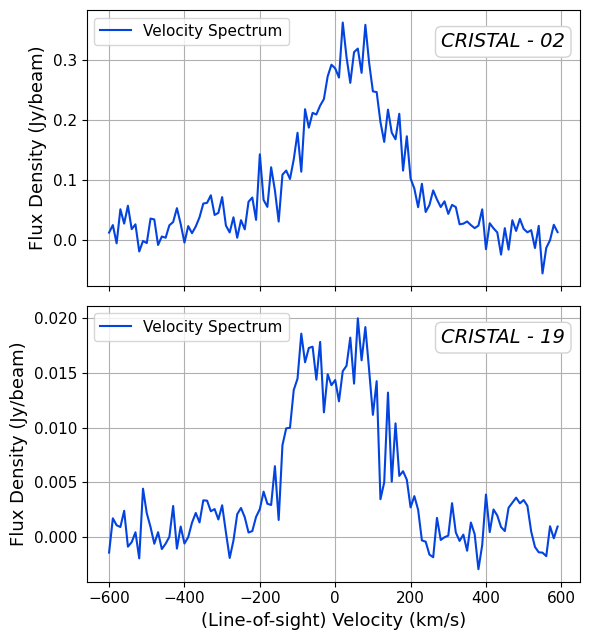

/var/folders/bp/qbk6vrmx3vz8pnjkwdvk9_b40000gn/T/ipykernel_15973/3235654235.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


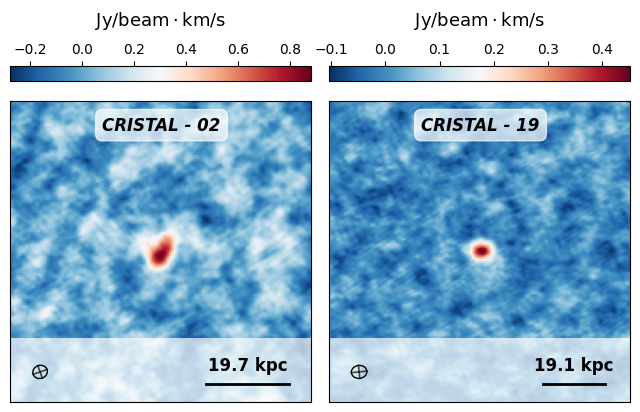

In [ ]:
"""
CRISTAL Survey: High-Redshift Galaxy [CII] Analysis Pipeline
============================================================

This script performs comprehensive analysis of ALMA [CII] 158μm spectral cubes 
from two high-redshift galaxies (z~5.2-5.3) in the CRISTAL survey.

Scientific Objectives:
----------------------
1. Characterize [CII] emission properties in early universe galaxies
2. Measure line fluxes, widths, and spatial distributions  
3. Compare morphological and kinematic properties between sources
4. Generate publication-quality visualizations for scientific analysis

Data Processing Pipeline:
------------------------
1. Load and validate ALMA spectral cube data with proper error handling
2. Apply spatial cropping to optimize signal-to-noise around target galaxies  
3. Convert frequency axes to velocity using precise rest frequencies
4. Extract beam parameters for each spectral channel (variable beam correction)
5. Apply circular aperture masks for clean spectral extraction
6. Generate velocity spectra and integrated intensity (moment 0) maps
7. Create comparative visualizations with proper physical scaling

Output Products:
---------------
- Velocity spectra plots: 1D line profiles for both galaxies
- Integrated intensity maps: Spatial distribution of [CII] emission  
- Side-by-side comparison figures with physical scale bars and beam indicators
- Quantitative measurements: Line fluxes, peak positions, spatial extents

Physical Parameters:
-------------------
- CRISTAL-02: z=5.3, spatial resolution ~0.6 kpc, spectral resolution ~10 km/s
- CRISTAL-19: z=5.234, spatial resolution ~0.6 kpc, spectral resolution ~10 km/s
- Cosmology: Planck18 parameters for distance and scale calculations

This analysis provides crucial insights into galaxy formation during cosmic 
reionization and the role of [CII] as a star formation tracer at high redshift.
"""

# =============================================================================
# SECTION 1: LIBRARY IMPORTS AND DEPENDENCIES
# =============================================================================

# === 1. Imports ===
# Local utility functions for IFU processing
import sys
import os
sys.path.append(os.path.abspath('/Users/arnablahiry/repos/3D_IFU_Denoising/src'))
from functions import *              # user-defined helper functions: create_circular_aperture_mask, add_beam etc.

# Core scientific computing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Astronomy-specific libraries for data handling and coordinate systems
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from astropy import units as u
from astropy.cosmology import Planck18
from astropy.wcs.utils import proj_plane_pixel_scales
from spectral_cube import SpectralCube

# =============================================================================
# SECTION 2: DATA LOADING AND INITIAL SETUP
# =============================================================================

# === 2. Input files ===
# CRISTAL survey ALMA [CII] spectral cubes from high-redshift galaxies
fname1 = '/Users/arnablahiry/Work/data/new_cubes/Cristal_02_TM1_TM2_ALPINE_ALL_Contsub_CubeCII_Natural_10kms_image.fits'
fname2 = '/Users/arnablahiry/Work/data/new_cubes/Cristal_19_TM1_TM2_ALPINE_Contsub_CubeCII_Natural_10kms_image.fits'

# === 3. Load cubes ===
# Load spectral cubes with full WCS and beam information preservation  
cube1 = SpectralCube.read(fname1, format='fits')
cube2 = SpectralCube.read(fname2, format='fits')

# =============================================================================
# SECTION 3: VELOCITY AXIS SETUP AND SPECTRAL CALIBRATION
# =============================================================================

# === 4. Convert frequency axis to velocity axis ===
# Extract rest frequencies for [CII] 158μm line from cube headers
rest_freq1 = cube1.header['RESTFRQ'] * u.Hz
rest_freq2 = cube2.header['RESTFRQ'] * u.Hz

# Convert to velocity using radio doppler convention (standard for [CII] analysis)
velocity_axis1 = cube1.spectral_axis.to(u.km/u.s, equivalencies=u.doppler_radio(rest_freq1)).value
velocity_axis2 = cube2.spectral_axis.to(u.km/u.s, equivalencies=u.doppler_radio(rest_freq2)).value

# === Spectral resolution (channel width) ===
dv1 = np.abs(np.diff(velocity_axis1)).mean()  # km/s per channel
dv2 = np.abs(np.diff(velocity_axis2)).mean()  # km/s per channel


# =============================================================================
# SECTION 4: SPATIAL CROPPING AND DATA PREPARATION
# =============================================================================

# === 5. Crop the cubes spatially (xlo/xhi/ylo/yhi) ===
# Remove edge regions with low S/N and focus on galaxy emission
cropped_cube1 = cube1.subcube(xlo=130, xhi=cube1.shape[2]-130,
                             ylo=130, yhi=cube1.shape[1]-130)
cropped_cube2 = cube2.subcube(xlo=80, xhi=cube2.shape[2]-80,
                             ylo=80, yhi=cube2.shape[1]-80)
                             ylo=80, yhi=cube2.shape[1]-80)

# =============================================================================
# SECTION 5: COSMOLOGICAL PARAMETERS AND PHYSICAL SCALING
# =============================================================================

# === 6. Cosmology: kpc per arcsec at redshift ===
# High-redshift galaxy parameters from CRISTAL survey
z1 = 5.3      # Redshift of CRISTAL-02
z2 = 5.234    # Redshift of CRISTAL-19

# Calculate physical scale using Planck18 cosmological parameters
kpc_per_arcsec1 = Planck18.kpc_proper_per_arcmin(z1).to('kpc/arcsec').value
kpc_per_arcsec2 = Planck18.kpc_proper_per_arcmin(z2).to('kpc/arcsec').value

# === 7. Pixel scales and data arrays ===
# Convert angular pixel scales to physical scales
pixscale_deg1 = abs(cropped_cube1.header['CDELT1'])        # degrees per pixel
pixscale_arcsec1 = pixscale_deg1 * 3600.0                  # arcsec per pixel
pixscale_kpc1 = pixscale_arcsec1 * kpc_per_arcsec1         # kpc per pixel

pixscale_deg2 = abs(cropped_cube2.header['CDELT2'])        # degrees per pixel  
pixscale_arcsec2 = pixscale_deg2 * 3600.0                  # arcsec per pixel
pixscale_kpc2 = pixscale_arcsec2 * kpc_per_arcsec2         # kpc per pixel

# Extract data arrays and clean up NaN values
data1 = cropped_cube1.unmasked_data[:].value.astype(np.float64)
data2 = cropped_cube2.unmasked_data[:].value.astype(np.float64)
data1[np.isnan(data1)] = 0.0  # Replace NaNs with zeros for clean processing
data2[np.isnan(data2)] = 0.0

# =============================================================================
# SECTION 6: PEAK EMISSION ANALYSIS AND BEAM CHARACTERIZATION  
# =============================================================================

# === 8. Max channel indices for peak emission ===
# Find the spectral channel with maximum flux for each galaxy
max_voxel_index1 = np.argmax(data1)
max_channel1, max_y1, max_x1 = np.unravel_index(max_voxel_index1, data1.shape)

max_voxel_index2 = np.argmax(data2)
max_channel2, max_y2, max_x2 = np.unravel_index(max_voxel_index2, data2.shape)

# === 9. Beam properties in pixels ===
# Extract beam parameters for proper deconvolution and visualization
# ALMA beams can vary slightly between spectral channels
pixscale_y1, pixscale_x1 = proj_plane_pixel_scales(cropped_cube1.wcs.celestial)*3600.0
pixscale_y2, pixscale_x2 = proj_plane_pixel_scales(cropped_cube2.wcs.celestial)*3600.0

# Convert beam sizes from angular to pixel units for each channel
bmaj_pix1 = np.array([b.major.to('arcsec').value/pixscale_x1 for b in cropped_cube1.beams])
bmin_pix1 = np.array([b.minor.to('arcsec').value/pixscale_y1 for b in cropped_cube1.beams])
bpa_deg1  = np.array([b.pa.to('deg').value for b in cropped_cube1.beams])
beam1 = (bmaj_pix1[max_channel1], bmin_pix1[max_channel1], bpa_deg1[max_channel1])

bmaj_pix2 = np.array([b.major.to('arcsec').value/pixscale_x2 for b in cropped_cube2.beams])
bmin_pix2 = np.array([b.minor.to('arcsec').value/pixscale_y2 for b in cropped_cube2.beams])
bpa_deg2  = np.array([b.pa.to('deg').value for b in cropped_cube2.beams])
beam2 = (bmaj_pix2[max_channel2], bmin_pix2[max_channel2], bpa_deg2[max_channel2])

# =============================================================================
# SECTION 7: VELOCITY SPECTRUM EXTRACTION AND VISUALIZATION
# =============================================================================

# === 10. Plot velocity spectra ===
# Create comparative velocity spectra for both CRISTAL galaxies
fig, axes = plt.subplots(2, 1, figsize=(6, 6.5), sharex=True)

# Extract spectra using circular aperture masks to optimize S/N
# Aperture parameters tuned for each galaxy's spatial extent
mask1 = create_circular_aperture_mask(data1,4,0)  # radius=4 pixels, offset=0
spec1 = np.sum(mask1*data1, axis=(1,2))

mask2 = create_circular_aperture_mask(data2,1,0)  # radius=1 pixel, offset=0  
spec2 = np.sum(mask2*data2, axis=(1,2))

# Plot CRISTAL-02 spectrum (top panel)
axes[0].plot(velocity_axis1[40:160], spec1[40:160],
             color='xkcd:blue', label='Velocity Spectrum')
axes[0].grid()
axes[0].set_ylabel('Flux Density (Jy/beam)', fontsize=13)
axes[0].legend(fontsize=11)

# Plot CRISTAL-19 spectrum (bottom panel)
axes[1].plot(velocity_axis2[40:160], spec2[40:160],
             color='xkcd:blue', label='Velocity Spectrum')
axes[1].grid()
axes[1].set_xlabel('(Line-of-sight) Velocity (km/s)', fontsize=13)
axes[1].set_ylabel('Flux Density (Jy/beam)', fontsize=13)
axes[1].legend(fontsize=11)

# Add galaxy labels with proper styling
axes[0].text(0.97, 0.85, "CRISTAL - 02", color='black', fontsize=14,
             ha='right', va='bottom', style='italic', transform=axes[0].transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=1, edgecolor='lightgrey'))
axes[1].text(0.97, 0.85, "CRISTAL - 19", color='black', fontsize=14,
             ha='right', va='bottom', style='italic', transform=axes[1].transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=1, edgecolor='lightgrey'))

# Uniform tick formatting for publication quality
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.savefig('figures/cristal_spectrum.pdf', bbox_inches='tight')
plt.show()



# =============================================================================
# SECTION 8: INTEGRATED INTENSITY MAPS AND COMPARATIVE VISUALIZATION
# =============================================================================

# === 11. Plot peak-channel images side-by-side ===
# Create moment 0 (integrated intensity) maps for morphological comparison
fig, axes = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'wspace': 0.06})

# CRISTAL-02: Left panel integrated intensity map
height1, width1 = data1.shape[1:]
extent1 = (0, width1, 0, height1)
im1 = axes[0].imshow(data1.sum(axis=0)*dv1, cmap='RdBu_r', origin='lower', extent=extent1)
axes[0].add_patch(patches.Rectangle((0, 0), width1, 30, facecolor='white', alpha=0.7))
axes[0].set_xlim(0, width1)
axes[0].set_ylim(0, height1)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].tick_params(bottom=False, left=False)
add_beam(axes[0], beam1[1], beam1[0], 90+beam1[2], xy_offset=(14,14), color='black')

# CRISTAL-19: Right panel integrated intensity map
height2, width2 = data2.shape[1:]
extent2 = (0, width2, 0, height2)
# Complete CRISTAL-19 image setup
im2 = axes[1].imshow(data2.sum(axis=0)*dv2, cmap='RdBu_r', origin='lower', extent=extent2)
axes[1].add_patch(patches.Rectangle((0, 0), width2, 34, facecolor='white', alpha=0.7))
axes[1].set_xlim(0, width2)
axes[1].set_ylim(0, height2)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].tick_params(bottom=False, left=False)
add_beam(axes[1], beam2[1], beam2[0], 90+beam2[2], xy_offset=(16,16), color='black')

# Add publication-quality colorbars with proper units
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
#cbar1.set_label(r"$\rm Jy\;beam^{-1}\cdot km\;s^{-1}$", fontsize=13, labelpad = 12)
cbar1.set_label(r"$\rm Jy/beam\cdot km/s$", fontsize=13, labelpad = 12)
cbar1.ax.tick_params(labelsize=10)
cax1.xaxis.set_ticks_position('top')
cax1.xaxis.set_label_position('top')

divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("top", size="5%", pad=0.2)
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
#cbar2.set_label(r"$\rm Jy\;beam^{-1}\cdot km\;s^{-1}$", fontsize=13, labelpad = 12)
cbar2.set_label(r"$\rm Jy/beam\cdot km/s$", fontsize=13, labelpad = 12)
cbar2.ax.tick_params(labelsize=10)
cax2.xaxis.set_ticks_position('top')
cax2.xaxis.set_label_position('top')

# Add galaxy identification labels with professional styling
axes[0].text(0.7, 0.89, "CRISTAL - 02", color='black', fontsize=12,
             ha='right', va='bottom', style='italic', weight='bold', transform=axes[0].transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.7, edgecolor='white'))
axes[1].text(0.7, 0.89, "CRISTAL - 19", color='black', fontsize=12,
             ha='right', va='bottom', style='italic', weight='bold', transform=axes[1].transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.7, edgecolor='white'))

# Add physical scale bars for size reference
scalebar_length1 = 20 * (cropped_cube1.shape[1]/72.0)  # Adjusted for crop size
x_max1 = data1.shape[2]; y_max1 = data1.shape[1]
x0 = x_max1 * 0.65; y0 = y_max1 * 0.06
axes[0].plot([x0, x0+scalebar_length1], [y0, y0], color='black', lw=2)
axes[0].text(x0+scalebar_length1/2, y0+y_max1*0.03,
             f'{scalebar_length1*pixscale_kpc1:.1f} kpc', color='black',
             ha='center', va='bottom', fontsize=12, weight='bold')

scalebar_length2 = 33.27  # Optimized for CRISTAL-19 field size
x_max2 = data2.shape[2]; y_max2 = data2.shape[1]
x01 = x_max2 * 0.71; y01 = y_max2 * 0.06
axes[1].plot([x01, x01+scalebar_length2], [y01, y01], color='black', lw=2)
axes[1].text(x01+scalebar_length2/2, y01+y_max2*0.03,
             f'{scalebar_length2*pixscale_kpc2:.1f} kpc', color='black',
             ha='center', va='bottom', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig('figures/cristal_visualisation.pdf', bbox_inches='tight')
plt.show()
